# my_loss.py のテスト

In [1]:
# モジュールimport
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from model import my_loss, define_model, multi_loss, my_class_weight

import numpy as np
np.random.seed(42)

Using TensorFlow backend.


my_loss.py: loaded as module file
define_model.py: loaded as module file
multi_loss.py: loaded as module file
my_class_weight.py: loaded as module file


In [2]:
from keras import backend as K

def get_base_model():
    out_dir='output_test/100x100'
    shape=[100, 100, 3]
    num_classes=5
    choice_model='VGG16'# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
    trainable=15
    FCnum=0
    FCpool='GlobalAveragePooling2D'
    activation='sigmoid'# ['sigmoid','softmax']

    model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                            , choice_model, trainable
                                                            , FCnum
                                                            , FCpool=FCpool
                                                            , activation=activation 
                                                          )
    #model.compile(loss=[my_loss.binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=optim)
    #model.summary()
    return model

C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


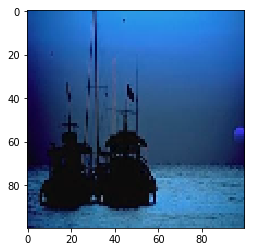

In [3]:
# Downloading and Viewing the dataset

import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
#Jupyterでインライン表示するための宣言
%matplotlib inline

num_classes=5
train_batch_size=68#17
valid_batch_size=37#6
epochs=20#5

def load():
    f = h5py.File("dataset.h5")
    x = f['x'].value
    y = f['y'].value
    f.close()
    
    x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=100)
    
    # Making the data channel last
    x_train = np.rollaxis(x_train, 1, 4)
    x_test = np.rollaxis(x_test, 1, 4)
    
    # Normalizing data
    x_train = x_train  / 255.0
    x_test = x_test / 255.0
   
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load()

horizontal_flip=True
vertical_flip=True
rotation_range=60
zoom_range=[0.5, 1.9]
shear_range=0.2

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
    rotation_range=rotation_range,  # randomly rotate images in the range (degrees, 0 to 180)
    horizontal_flip=horizontal_flip,  # randomly flip images
    vertical_flip=vertical_flip,  # randomly flip images
    shear_range = shear_range,
    zoom_range=zoom_range
)

plt.imshow(x_train[0])

In [4]:
model = get_base_model()
model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
              , optimizer=define_model.get_optimizers('sgd')
              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy])

model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                    , steps_per_epoch=x_train.shape[0] // train_batch_size
                                    , epochs=epochs
                                    , validation_data=(x_test, y_test)
                                    , verbose=1)

----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 15
FCnum = 0
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v3\lib\site-packages\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- FC_layer -----
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.0 True
Epoch 1/20
23/23 [==============================] - 5s 196ms/step - loss: 0.5711 - acc: 0.2824 - binary_accuracy: 0.7534 - masked_accuracy: 0.7534 - val_loss: 0.5477 - val_acc: 0.2600 - val_binary_accuracy: 0.7525 - val_masked_accuracy: 0.7525
Epoch 2/20
23/23 [==============================] - 3s 131ms/step - loss: 0.5220 - acc: 0.3780 - binary_accuracy: 0.7571 - masked_accuracy: 0.7571 - val_loss: 0.4885 - val_acc: 0.4475 - val_binary_accuracy: 0.7690 - val_masked_accuracy: 0.7690
Epoch 3/20
23/23 [==============================] - 3s 129ms/step - loss: 0.4529 - acc: 0.4470 - binary_accuracy: 0.7911 - masked_accuracy: 0.7911 - val_loss: 0.3961 - val_acc: 0.5600 - val_binary_accuracy: 0.8245 - val_masked_accuracy: 0.8245
Epoch 4/20
23/23 [==============================] - 3s 129ms/step - loss: 0.4012 - acc: 0.5223 - binary_accuracy: 0.8164 - masked_accuracy: 0.8164 - val_lo

In [5]:
model = get_base_model()
model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
              , optimizer=define_model.get_optimizers('sgd')
              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy])

# クラスの不均衡を考慮して、トレーニングデータのclass_weight
class_weight = my_class_weight.cal_weight_flow(y_train)
print(class_weight)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                    , steps_per_epoch=x_train.shape[0] // train_batch_size
                                    , epochs=epochs
                                    , validation_data=(x_test, y_test)
                                    , verbose=1
                                    , class_weight=class_weight)

----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 15
FCnum = 0
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.0 True
{0: 1.47, 1: 1.31, 2: 1.0, 3: 1.26, 4: 1.1}
Epoch 1/20
23/23 [==============================] - 4s 157ms/step - loss: 0.6943 - acc: 0.2438 - binary_accuracy: 0.7532 - masked_accuracy: 0.7532 - val_loss: 0.5515 - val_acc: 0.2100 - val_binary_accuracy: 0.7525 - val_masked_accuracy: 0.7525
Epoch 2/20
23/23 [==============================] - 3s 145ms/step - loss: 0.6275 - acc: 0.4045 - binary_accuracy: 0.7602 - masked_accuracy: 0.7602 - val_loss: 0.4725 - val_acc: 0.5125 - val_binary_accuracy: 0.7865 - val_masked_accuracy: 0.7865
Epoch 3/20
23/23 [==============================] - 3s 141ms/step

In [6]:
model = get_base_model()
model.compile(loss=K.binary_crossentropy
              , optimizer=define_model.get_optimizers('sgd')
              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy])

# クラスの不均衡のclass_weightあえておかしくしてみる
class_weight = {0: 100000.47, 1: 1.31, 2: 1.0, 3: 10000000.26, 4: 1.1}
print(class_weight)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                    , steps_per_epoch=x_train.shape[0] // train_batch_size
                                    , epochs=epochs
                                    , validation_data=(x_test, y_test)
                                    , verbose=1
                                    , class_weight=class_weight)

----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 15
FCnum = 0
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.0 True
{0: 100000.47, 1: 1.31, 2: 1.0, 3: 10000000.26, 4: 1.1}
Epoch 1/20
23/23 [==============================] - 3s 143ms/step - loss: 7722858.0135 - acc: 0.1294 - binary_accuracy: 0.6511 - masked_accuracy: 0.6511 - val_loss: 12635330.8300 - val_acc: 0.1100 - val_binary_accuracy: 0.6395 - val_masked_accuracy: 0.6395
Epoch 2/20
23/23 [==============================] - 3s 132ms/step - loss: 14597869.9504 - acc: 0.1280 - binary_accuracy: 0.6493 - masked_accuracy: 0.6493 - val_loss: 14698939.8300 - val_acc: 0.1100 - val_binary_accuracy: 0.6395 - val_masked_accuracy: 0.6395
Epoch 3/20
23/23 [========

**<font color="Red">→マルチラベルでもclass_weightやっぱ効いてる</font>**  



In [7]:
model = get_base_model()
model.compile(loss=my_loss.binary_focal_loss(alpha=1.0, gamma=0)
              , metrics=["accuracy", 'binary_accuracy', multi_loss.masked_accuracy]
              , optimizer=define_model.get_optimizers('sgd'))

model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                    , steps_per_epoch=x_train.shape[0] // train_batch_size
                                    , epochs=epochs
                                    , validation_data=(x_test, y_test)
                                    , verbose=1)

----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 15
FCnum = 0
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.0 True
Epoch 1/20
23/23 [==============================] - 3s 141ms/step - loss: 2.4655 - acc: 0.2048 - binary_accuracy: 0.2696 - masked_accuracy: 0.2696 - val_loss: 0.0401 - val_acc: 0.2100 - val_binary_accuracy: 0.2475 - val_masked_accuracy: 0.2475
Epoch 2/20
23/23 [==============================] - 3s 137ms/step - loss: 0.0444 - acc: 0.2025 - binary_accuracy: 0.2479 - masked_accuracy: 0.2479 - val_loss: 0.0467 - val_acc: 0.2100 - val_binary_accuracy: 0.2475 - val_masked_accuracy: 0.2475
Epoch 3/20
23/23 [==============================] - 3s 135ms/step - loss: 0.0470 - acc: 0.2007 - binary_accur

In [8]:
model = get_base_model()
model.compile(loss=my_loss.binary_focal_loss(alpha=0.25, gamma=2)
              , metrics=["accuracy", 'binary_accuracy', multi_loss.masked_accuracy]
              , optimizer=define_model.get_optimizers('sgd'))

model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                    , steps_per_epoch=x_train.shape[0] // train_batch_size
                                    , epochs=epochs
                                    , validation_data=(x_test, y_test)
                                    , verbose=1)

----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 15
FCnum = 0
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.0 True
Epoch 1/20
23/23 [==============================] - 3s 140ms/step - loss: 319.0213 - acc: 0.2432 - binary_accuracy: 0.7520 - masked_accuracy: 0.7520 - val_loss: 333.2620 - val_acc: 0.2100 - val_binary_accuracy: 0.7525 - val_masked_accuracy: 0.7525
Epoch 2/20
23/23 [==============================] - 3s 132ms/step - loss: 332.3714 - acc: 0.2053 - binary_accuracy: 0.7524 - masked_accuracy: 0.7524 - val_loss: 333.2719 - val_acc: 0.2100 - val_binary_accuracy: 0.7525 - val_masked_accuracy: 0.7525
Epoch 3/20
23/23 [==============================] - 3s 137ms/step - loss: 338.2008 - acc: 0.1995 - bi

In [9]:
multi_label_focal_loss = my_loss.multi_label_focal_loss([100, 100, 100, 100, 100], alpha=0.25, gamma=2)
model.compile(loss=multi_loss.build_masked_loss(multi_label_focal_loss)
              , metrics=["accuracy", 'binary_accuracy', multi_loss.masked_accuracy]
              , optimizer=define_model.get_optimizers('sgd'))

model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                    , steps_per_epoch=x_train.shape[0] // train_batch_size
                                    , epochs=epochs
                                    , validation_data=(x_test, y_test)
                                    , verbose=1)

---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.0 True
Epoch 1/20
23/23 [==============================] - 3s 148ms/step - loss: nan - acc: 0.2017 - binary_accuracy: 0.0333 - masked_accuracy: 0.0333 - val_loss: nan - val_acc: 0.2100 - val_binary_accuracy: 0.0000e+00 - val_masked_accuracy: 0.0000e+00
Epoch 2/20
23/23 [==============================] - 3s 140ms/step - loss: nan - acc: 0.2009 - binary_accuracy: 0.0000e+00 - masked_accuracy: 0.0000e+00 - val_loss: nan - val_acc: 0.2100 - val_binary_accuracy: 0.0000e+00 - val_masked_accuracy: 0.0000e+00
Epoch 3/20
23/23 [==============================] - 3s 128ms/step - loss: nan - acc: 0.2032 - binary_accuracy: 0.0000e+00 - masked_accuracy: 0.0000e+00 - val_loss: nan - val_acc: 0.2100 - val_binary_accuracy: 0.0000e+00 - val_masked_accuracy: 0.0000e+00
Epoch 4/20
23/23 [==============================] - 3s 128ms/step - loss: nan - acc: 0.2109 - binary_accuracy: 0.0000e+00 - masked_accuracy: 0.0000e+00 - 

## 不均衡データセットに対する焦点喪失を伴う多クラス分類
- https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/
- https://github.com/Tony607/Focal_Loss_Keras
- 非常に不均衡なデータセットが与えられた場合に焦点損失を適用してマルチクラス分類器モデルを学習させる方法
    - 合計6354407の正常および8213の不正行為事例、すなわち 733：1の極端なクラス不均衡データで試す
    - https://www.kaggle.com/ntnu-testimon/paysim1

### class_weightを使って  訓練するベースラインモデルを設定する場合

### focal lossを使って  訓練

In [10]:
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from model import my_loss, define_model, multi_loss

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
np.random.seed(42)

# https://github.com/umbertogriffo/focal-loss-keras
import dill
multi_label_focal_loss = my_loss.multi_label_focal_loss([6354407, 8213], alpha=0.25, gamma=2)
custom_object = {'binary_focal_loss_fixed': dill.loads(dill.dumps(my_loss.binary_focal_loss(gamma=2., alpha=.25))),
                 'categorical_focal_loss_fixed': dill.loads(dill.dumps(my_loss.categorical_focal_loss(gamma=2., alpha=.25))),
                 'categorical_focal_loss': my_loss.categorical_focal_loss,
                 'binary_focal_loss': my_loss.binary_focal_loss,
                 'masked_loss_function': dill.loads(dill.dumps(multi_loss.build_masked_loss(multi_label_focal_loss, mask_value=multi_loss.mask_value)))
                }

In [11]:
def get_imbalance_train_data():
    """ 超不均衡多クラス分類データ取得 """
    # create data frame containing your data, each column can be accessed # by df['column   name']
    dataset = pd.read_csv(r'D:\work\kaggle_data\fraud_detection_dataset_on_Kaggle\paysim1/PS_20174392719_1491204439457_log.csv')
    del dataset['nameDest']
    del dataset['nameOrig']
    del dataset['type']
    #display(dataset.head())
    print(dataset['isFraud'].value_counts())
    
    def feature_normalize(dataset):
        mu = np.mean(dataset, axis=0)
        sigma = np.std(dataset, axis=0)
        return (dataset - mu) / sigma
    
    #Splitting the Training/Test Data
    from sklearn.model_selection  import train_test_split
    X, y = dataset.iloc[:,:-2], dataset.iloc[:, -2]
    y = keras.utils.to_categorical(y, num_classes=2)
    X = feature_normalize(X.as_matrix())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    return X_train, X_test, y_train, y_test

def train_imbalance_model(my_loss = my_loss.categorical_focal_loss(alpha=0.25, gamma=2)
                          , class_weight = None
                          , activation = 'softmax'):
    """ 超不均衡データで lossとclass_weight 変えたときの多クラス分類モデル比較 """
    print("########################################################")
    
    X_train, X_test, y_train, y_test = get_imbalance_train_data()
    
    from keras.models import Sequential
    import tensorflow as tf
    from keras.layers import Dense

    input_dim = X_train.shape[1]
    nb_classes = y_train.shape[1]
    
    model = Sequential()
    model.add(Dense(10, input_dim=input_dim, activation='relu', name='input'))
    model.add(Dense(20, activation='relu', name='fc1'))
    model.add(Dense(10, activation='relu', name='fc2'))
    model.add(Dense(nb_classes, activation=activation, name='output'))

    model.compile(loss=my_loss
                  , metrics=["accuracy"]
                  , optimizer='nadam')
    #model.summary()

    if class_weight is not None:
        model.fit(X_train, y_train, epochs=3, batch_size=1000, class_weight=class_weight)
    else:
        model.fit(X_train, y_train, epochs=3, batch_size=1000)
        
    model.save(r'output_test\model.h5')#, include_optimizer=False)    
    model = keras.models.load_model(r'output_test\model.h5', custom_objects=custom_object)#, compile=False,
    
    score = model.evaluate(X_test, y_test, batch_size=1000)
    print(f'score:{score}')

    from sklearn import metrics
    predictions = model.predict(X_test, batch_size=1000)
    max_test = np.argmax(y_test, axis=1)
    max_predictions = np.argmax(predictions, axis=1)
    confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
    values = confusion_matrix.view()
    error_count = values.sum() - np.trace(values)
    print(f'error_count:{error_count}\n')
    
    return confusion_matrix


In [12]:
# class_weight無い方がaccracy高いという。。。
confusion_matrix0 = train_imbalance_model(my_loss = 'categorical_crossentropy')
confusion_matrix1 = train_imbalance_model(my_loss = 'categorical_crossentropy', class_weight = {0 : 1., 1: 733.})

########################################################
0    6354407
1       8213
Name: isFraud, dtype: int64


C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(5090096, 6) (1272524, 6) (5090096, 2) (1272524, 2)
Epoch 1/3
5090096/5090096 [==============================] - 22s 4us/step - loss: 0.0088 - acc: 0.9990
Epoch 2/3
5090096/5090096 [==============================] - 21s 4us/step - loss: 0.0038 - acc: 0.9993
Epoch 3/3
1272524/1272524 [==============================] - 2s 1us/step
score:[0.0035741054131302368, 0.9993524749399884]
error_count:824

########################################################
0    6354407
1       8213
Name: isFraud, dtype: int64
(5090096, 6) (1272524, 6) (5090096, 2) (1272524, 2)
Epoch 1/3
5090096/5090096 [==============================] - 22s 4us/step - loss: 0.5677 - acc: 0.9298
Epoch 2/3
5090096/5090096 [==============================] - 21s 4us/step - loss: 0.3836 - acc: 0.9429
Epoch 3/3
1272524/1272524 [==============================] - 2s 1us/step
score:[0.12134754008696981, 0.9629995182864451]
error_count:47084



In [13]:
# my_loss.categorical_focal_loss はうまく機能しているっぽい
confusion_matrix2 = train_imbalance_model(my_loss = my_loss.categorical_focal_loss(alpha=0.0, gamma=0))
confusion_matrix3 = train_imbalance_model(my_loss = my_loss.categorical_focal_loss(alpha=1.0, gamma=0))
confusion_matrix4 = train_imbalance_model(my_loss = my_loss.categorical_focal_loss(alpha=0.25, gamma=2)) 
confusion_matrix5 = train_imbalance_model(my_loss = my_loss.categorical_focal_loss(alpha=0.75, gamma=5))

########################################################
0    6354407
1       8213
Name: isFraud, dtype: int64


C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(5090096, 6) (1272524, 6) (5090096, 2) (1272524, 2)
Epoch 1/3
5090096/5090096 [==============================] - 24s 5us/step - loss: 0.0000e+00 - acc: 0.0477
Epoch 2/3
5090096/5090096 [==============================] - 22s 4us/step - loss: 0.0000e+00 - acc: 0.0477
Epoch 3/3
1272524/1272524 [==============================] - 2s 1us/step
score:[0.08258974492075598, 0.047507944922571876]
error_count:1212069

########################################################
0    6354407
1       8213
Name: isFraud, dtype: int64
(5090096, 6) (1272524, 6) (5090096, 2) (1272524, 2)
Epoch 1/3
5090096/5090096 [==============================] - 22s 4us/step - loss: 0.0081 - acc: 0.9989
Epoch 2/3
5090096/5090096 [==============================] - 22s 4us/step - loss: 0.0035 - acc: 0.9993
Epoch 3/3
1272524/1272524 [==============================] - 2s 1us/step
score:[0.0006941127830983835, 0.9993469738980426]
error_count:831

########################################################
0    6354407
1       821

In [14]:
# my_loss.binary_focal_loss もうまく機能しているっぽい
confusion_matrix6 = train_imbalance_model(my_loss = my_loss.binary_focal_loss(alpha=0.25, gamma=2), activation = 'sigmoid') 

########################################################
0    6354407
1       8213
Name: isFraud, dtype: int64


C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(5090096, 6) (1272524, 6) (5090096, 2) (1272524, 2)
Epoch 1/3
5090096/5090096 [==============================] - 21s 4us/step - loss: 3.6778 - acc: 0.9957
Epoch 2/3
5090096/5090096 [==============================] - 20s 4us/step - loss: 0.9741 - acc: 0.9993
Epoch 3/3
1272524/1272524 [==============================] - 2s 2us/step
score:[0.8148126895805322, 0.9993807645273647]
error_count:788



In [15]:
# my_loss.binary_focal_loss()をmulti_loss.build_masked_loss()にかぶせるとなせか精度下がる。。。
confusion_matrix7 = train_imbalance_model(my_loss = multi_loss.build_masked_loss(my_loss.binary_focal_loss(alpha=0.25, gamma=2))
                                          , activation = 'sigmoid')

confusion_matrix7 = train_imbalance_model(my_loss = multi_loss.build_masked_loss(my_loss.binary_focal_loss(alpha=0.25, gamma=2), mask_value=-1)
                                          , activation = 'sigmoid')

########################################################
0    6354407
1       8213
Name: isFraud, dtype: int64


C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(5090096, 6) (1272524, 6) (5090096, 2) (1272524, 2)
Epoch 1/3
5090096/5090096 [==============================] - 20s 4us/step - loss: 3.2237 - acc: 0.9969
Epoch 2/3
5090096/5090096 [==============================] - 20s 4us/step - loss: 1.0438 - acc: 0.9993
Epoch 3/3
1272524/1272524 [==============================] - 2s 2us/step
score:[1.1293319216526774, 0.9993399012435802]
error_count:840

########################################################
0    6354407
1       8213
Name: isFraud, dtype: int64
(5090096, 6) (1272524, 6) (5090096, 2) (1272524, 2)
Epoch 1/3
5090096/5090096 [==============================] - 21s 4us/step - loss: 2.3237 - acc: 0.9986
Epoch 2/3
5090096/5090096 [==============================] - 20s 4us/step - loss: 0.9613 - acc: 0.9993
Epoch 3/3
1272524/1272524 [==============================] - 2s 2us/step
score:[0.973292135651342, 0.999361904661928]
error_count:812



In [16]:
# my_loss.multi_label_focal_lossはやっぱなんかおかしい
confusion_matrix8 = train_imbalance_model(my_loss = multi_loss.build_masked_loss(multi_label_focal_loss), activation = 'sigmoid')

########################################################
0    6354407
1       8213
Name: isFraud, dtype: int64


C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(5090096, 6) (1272524, 6) (5090096, 2) (1272524, 2)
Epoch 1/3
5090096/5090096 [==============================] - 26s 5us/step - loss: 0.0705 - acc: 0.9966
Epoch 2/3
5090096/5090096 [==============================] - 25s 5us/step - loss: 0.0693 - acc: 0.9987
Epoch 3/3
1272524/1272524 [==============================] - 2s 2us/step
score:[0.06931471831671951, 0.9983788200555131]
error_count:2063



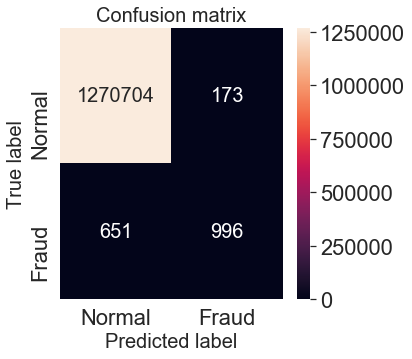

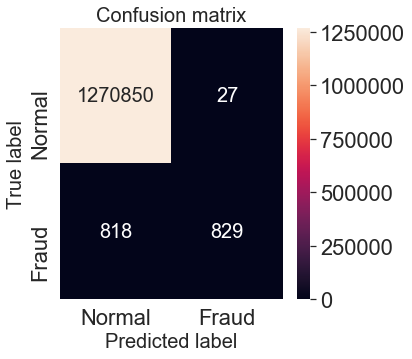

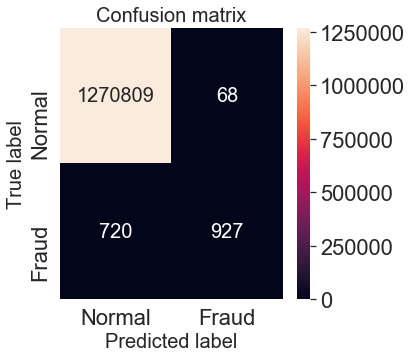

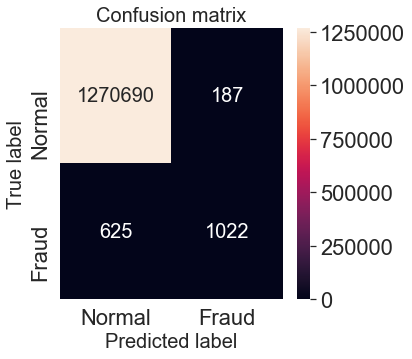

In [17]:
def plot_seaborn_conf_matrix(confusion_matrix):
    """ seabornで混同行列plot """
    %matplotlib inline
    from sklearn import metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(font_scale=2)
    #predictions = model.predict(X_test, batch_size=1000)
    LABELS = ['Normal','Fraud'] 
    #max_test = np.argmax(y_test, axis=1)
    #max_predictions = np.argmax(predictions, axis=1)
    #confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
    plt.title("Confusion matrix", fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.show()
    
plot_seaborn_conf_matrix(confusion_matrix0)
plot_seaborn_conf_matrix(confusion_matrix4)
plot_seaborn_conf_matrix(confusion_matrix6)
plot_seaborn_conf_matrix(confusion_matrix7)

In [18]:
X_train, X_test, y_train, y_test = get_imbalance_train_data()
y_train[0]

0    6354407
1       8213
Name: isFraud, dtype: int64


C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(5090096, 6) (1272524, 6) (5090096, 2) (1272524, 2)


array([1., 0.])